In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import os
import math
import pickle
import numpy as np
import scanpy as sc
from glob import glob
import pandas as pd
from scipy.stats import ranksums, ttest_ind, chi2_contingency
from copy import deepcopy
import matplotlib.pyplot as plt
from pylab import *
from matplotlib import pyplot
from matplotlib_venn import venn2,venn2_circles
from brokenaxes import brokenaxes
import seaborn as sns
from adjustText import adjust_text

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams["font.sans-serif"] = "Arial"

In [3]:
sc.set_figure_params(fontsize=20)

In [4]:
indir = '~/decidua/10xVisium/file/new/SPACEL'

In [5]:
normal_slices = ['A1_N59','B1_N59','C1_N56','D1_N56','C1_N65','D1_N65']
disease_slices = ['B1_P4','C1_P8B','D1_P9T','D1_P9B']

In [6]:
space_dict = {}
for slide in normal_slices+disease_slices:
    path = os.path.join(indir,f'{slide}.count.h5ad')
    space_data = sc.read_h5ad(path)
    space_dict[slide] = space_data

# cell type distribution

In [7]:
order_ctypes2 = ['dS3','dS2','dNK1','dM2','dNKp',
                 'Endo','Epi','CD4T','dNK3','dS1',
                 'dNK2','dM1','PV','CD8T','Treg','DC','EVT']

In [8]:
df_ls = []
for slide in normal_slices:
    space_data = space_dict[slide]
    celltype_deconv_df = pd.read_csv(indir+'/scaled_ctype_proportion.per_spot.'+slide+'.csv', 
                                     index_col=0)
    celltype_deconv_df = celltype_deconv_df.loc[:,order_ctypes2]
    celltype_deconv_df = celltype_deconv_df.divide(celltype_deconv_df.sum(axis=1), axis=0)
    celltype_deconv_df['Domain'] = space_data.obs.loc[celltype_deconv_df.index,'Domain']
    domain_celltype_deconv_df = celltype_deconv_df.groupby('Domain').mean()
    domain_celltype_deconv_df.index = [x+'-'+slide for x in domain_celltype_deconv_df.index]
    df_ls.append(domain_celltype_deconv_df)
    
norm_domain_celltype_deconv_df = pd.concat(df_ls)
norm_rows = norm_domain_celltype_deconv_df.index.tolist()
norm_rows.sort()

df_ls = []
for slide in disease_slices:
    space_data = space_dict[slide]
    celltype_deconv_df = pd.read_csv(indir+'/scaled_ctype_proportion.per_spot.'+slide+'.csv', 
                                     index_col=0)
    celltype_deconv_df = celltype_deconv_df.loc[:,order_ctypes2]
    celltype_deconv_df = celltype_deconv_df.divide(celltype_deconv_df.sum(axis=1), axis=0)
    celltype_deconv_df['Domain'] = space_data.obs.loc[celltype_deconv_df.index,'Domain']
    domain_celltype_deconv_df = celltype_deconv_df.groupby('Domain').mean()
    domain_celltype_deconv_df.index = [x+'-'+slide for x in domain_celltype_deconv_df.index]
    df_ls.append(domain_celltype_deconv_df)
    
rpl_domain_celltype_deconv_df = pd.concat(df_ls)
rpl_rows = rpl_domain_celltype_deconv_df.index.tolist()
rpl_rows.sort()

In [9]:
concat_domain_celltype_deconv_df = pd.concat([norm_domain_celltype_deconv_df.loc[norm_rows].T, rpl_domain_celltype_deconv_df.loc[rpl_rows].T], axis=1)

In [10]:
tmp_norm_df = deepcopy(norm_domain_celltype_deconv_df)
tmp_norm_df['group'] = tmp_norm_df.index.map(lambda x: x.split('-')[0])

tmp_rpl_df = deepcopy(rpl_domain_celltype_deconv_df)
tmp_rpl_df['group'] = tmp_rpl_df.index.map(lambda x: x.split('-')[0])

In [11]:
result_norm_df = pd.melt(tmp_norm_df, id_vars=['group'], value_vars=order_ctypes2)
result_rpl_df = pd.melt(tmp_rpl_df, id_vars=['group'], value_vars=order_ctypes2)

In [12]:
logfc_df = pd.DataFrame(index=order_ctypes2, columns=['Domain1','Domain2'])
pval_df = pd.DataFrame(index=order_ctypes2, columns=['Domain1','Domain2'])

for ctype in order_ctypes2:
    for domain in ['Domain1','Domain2']:
        norm_ay = result_norm_df[(result_norm_df['group']==domain) & (result_norm_df['variable']==ctype)]['value']
        rpl_ay = result_rpl_df[(result_rpl_df['group']==domain) & (result_rpl_df['variable']==ctype)]['value']
        logfc_df.loc[ctype,domain] = np.log2(rpl_ay.mean() / norm_ay.mean())
        # pval_df.loc[ctype,domain] = ranksums(norm_ay, rpl_ay)[1]
        pval_df.loc[ctype,domain] = ttest_ind(norm_ay, rpl_ay, equal_var=False)[1]

logfc_df = logfc_df.applymap(float)
pval_df = pval_df.applymap(float)

In [13]:
concat_domain_celltype_deconv_df = pd.concat([norm_domain_celltype_deconv_df.loc[norm_rows].T.iloc[:,:6], 
                                              rpl_domain_celltype_deconv_df.loc[rpl_rows].T.iloc[:,:4],
                                              norm_domain_celltype_deconv_df.loc[norm_rows].T.iloc[:,6:], 
                                              rpl_domain_celltype_deconv_df.loc[rpl_rows].T.iloc[:,4:]], axis=1)

In [16]:
order_ctypes4 = ['dNK1','dM2','dS2','dNKp','dM1','dS1',
                 'DC','EVT','Treg','dNK2','PV','dNK3',
                 'CD4T','dS3','Endo','CD8T','Epi']
concat_domain_celltype_deconv_df = concat_domain_celltype_deconv_df.loc[order_ctypes4]

In [23]:
color_df = pd.DataFrame(index=concat_domain_celltype_deconv_df.columns)
color_df['State'] = color_df.index.map(lambda x: '#6299c5' if re.search('_N',x) else '#cc453a')

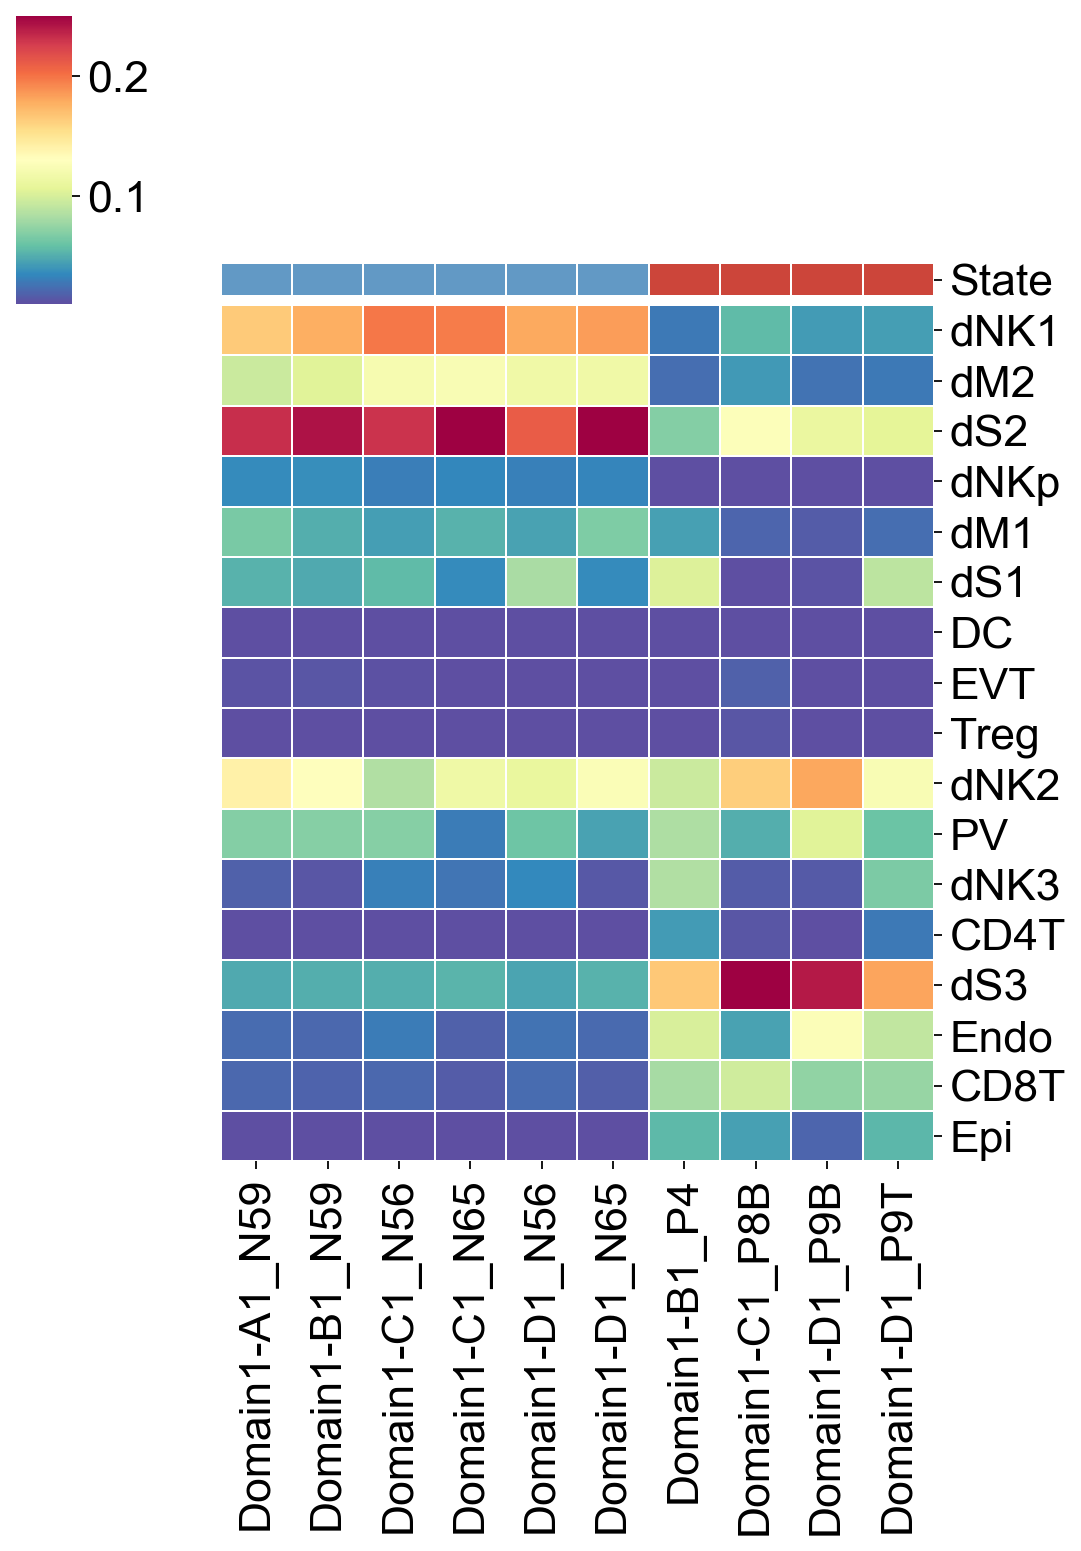

In [33]:
sns.clustermap(concat_domain_celltype_deconv_df.iloc[:,:10], cmap='Spectral_r', 
               vmax=0.25, vmin=0.01, linewidth=.1, row_cluster=False, col_cluster=False, 
               col_colors=color_df.iloc[:10], figsize=(7,10))

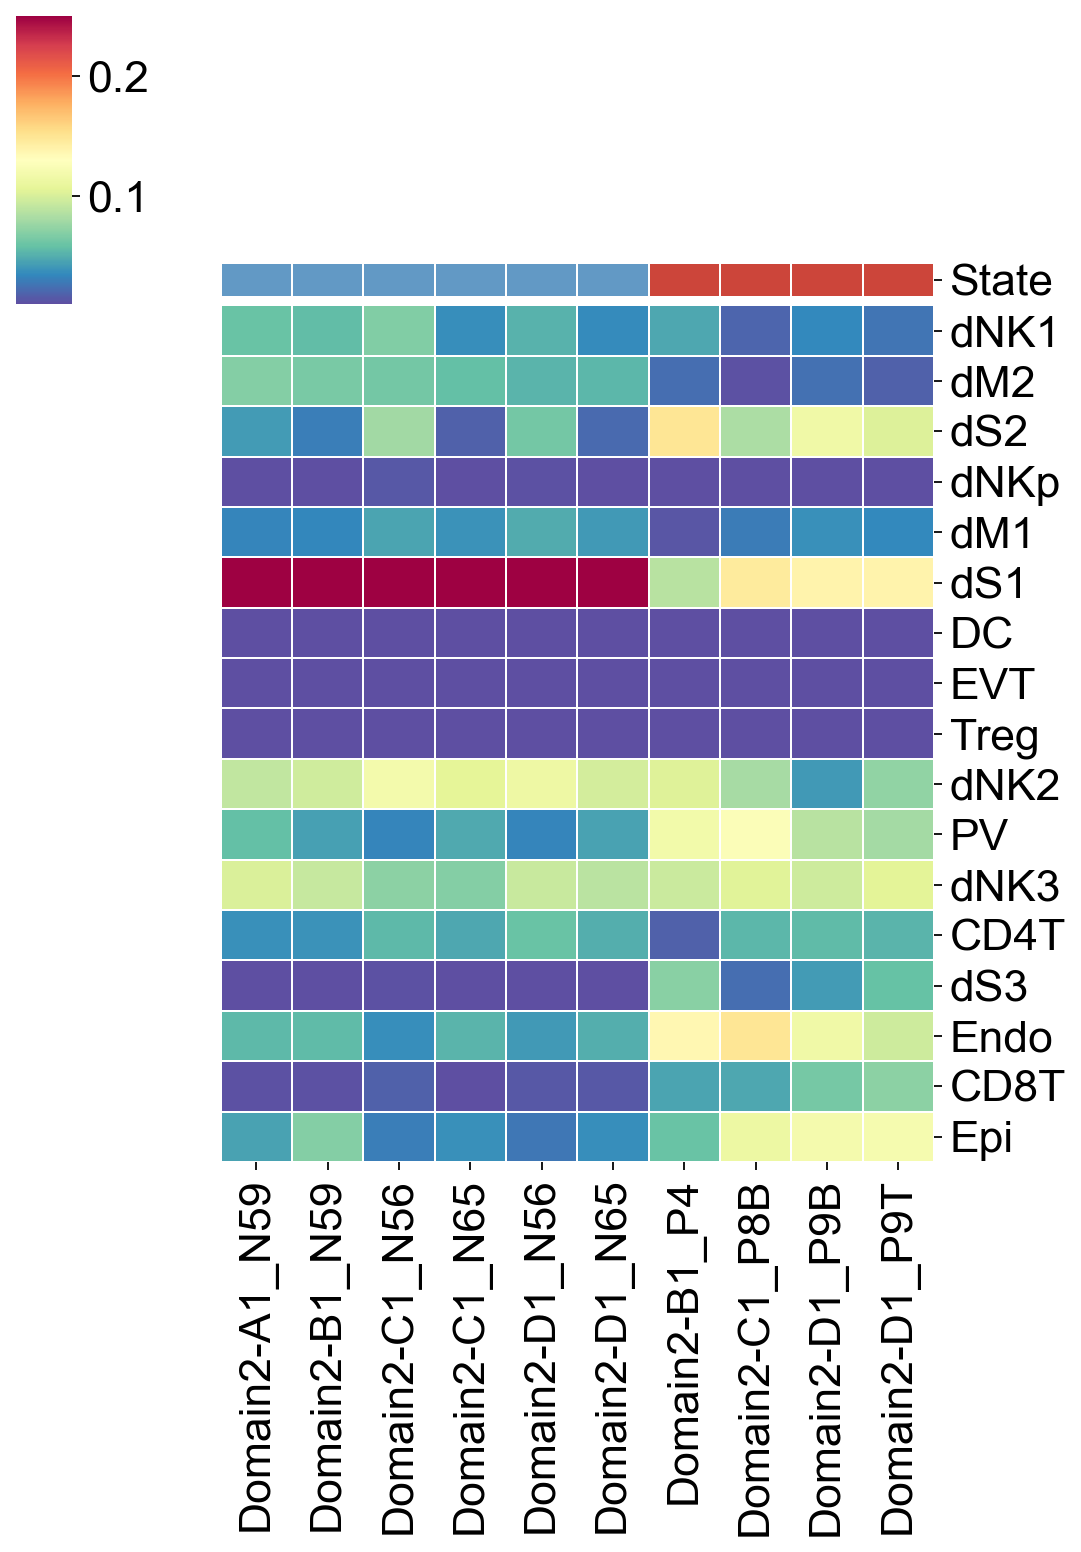

In [34]:
sns.clustermap(concat_domain_celltype_deconv_df.iloc[:,10:], cmap='Spectral_r', 
               vmax=0.25, vmin=0.01, linewidth=.1, row_cluster=False, col_cluster=False, 
               col_colors=color_df.iloc[10:], figsize=(7,10))

In [ ]:
# cell type collocalization

In [35]:
path = os.path.join(indir,'RPL_crop_coord.pkl')
with open(path, 'rb') as handle:
    coord_dict = pickle.load(handle)

In [36]:
normal_slices = ['A1_N59','B1_N59','C1_N56','D1_N56','C1_N65','D1_N65']
disease_slices = ['B1_P4','C1_P8B','D1_P9T','D1_P9B']

In [37]:
space_dict = {}
for slide in normal_slices+disease_slices:
    path = os.path.join(indir,f'{slide}.count.h5ad')
    space_data = sc.read_h5ad(path)
    space_dict[slide] = space_data

In [39]:
order_ctypes2 = ['dNKp','dNK1','dNK2','dNK3','dM1','dM2','CD4T','CD8T','Treg',
                'DC','dS1','dS2','dS3','Epi','Endo','PV','EVT']

In [40]:
norm_df_ls = []
for slide in normal_slices:
    space_data = space_dict[slide]
    prob_df = space_data.obs[[x+'_abundance' for x in order_ctypes2]]
    prob_df.columns = [x.split('_')[0] for x in prob_df.columns]
    corr_df = prob_df.corr()
    corr_df[corr_df<0] = 0
    nb_top = 5
    for ctype in order_ctypes2:
        pos_ctypes = corr_df[ctype][corr_df[ctype]>0].sort_values(ascending=False).index.tolist()[:nb_top]
        other_ctypes = list(set(order_ctypes2)-set(pos_ctypes))
        corr_df.loc[other_ctypes, ctype] = 0
        corr_df.loc[ctype, other_ctypes] = 0
        
    norm_df_ls.append(corr_df)

In [41]:
mean_norm_corr_df = (norm_df_ls[0]+norm_df_ls[1]+norm_df_ls[2]+norm_df_ls[3]+norm_df_ls[4]+norm_df_ls[5])/6

In [42]:
rpl_df_ls = []
for slide in disease_slices:
    space_data = space_dict[slide]
    prob_df = space_data.obs[[x+'_abundance' for x in order_ctypes2]]
    prob_df.columns = [x.split('_')[0] for x in prob_df.columns]
    corr_df = prob_df.corr()
    corr_df[corr_df<0] = 0
    nb_top = 5
    for ctype in order_ctypes2:
        pos_ctypes = corr_df[ctype][corr_df[ctype]>0].sort_values(ascending=False).index.tolist()[:nb_top]
        other_ctypes = list(set(order_ctypes2)-set(pos_ctypes))
        corr_df.loc[other_ctypes, ctype] = 0
        corr_df.loc[ctype, other_ctypes] = 0
        
    rpl_df_ls.append(corr_df)

In [43]:
mean_rpl_corr_df = (rpl_df_ls[0]+rpl_df_ls[1]+rpl_df_ls[2]+rpl_df_ls[3])/4

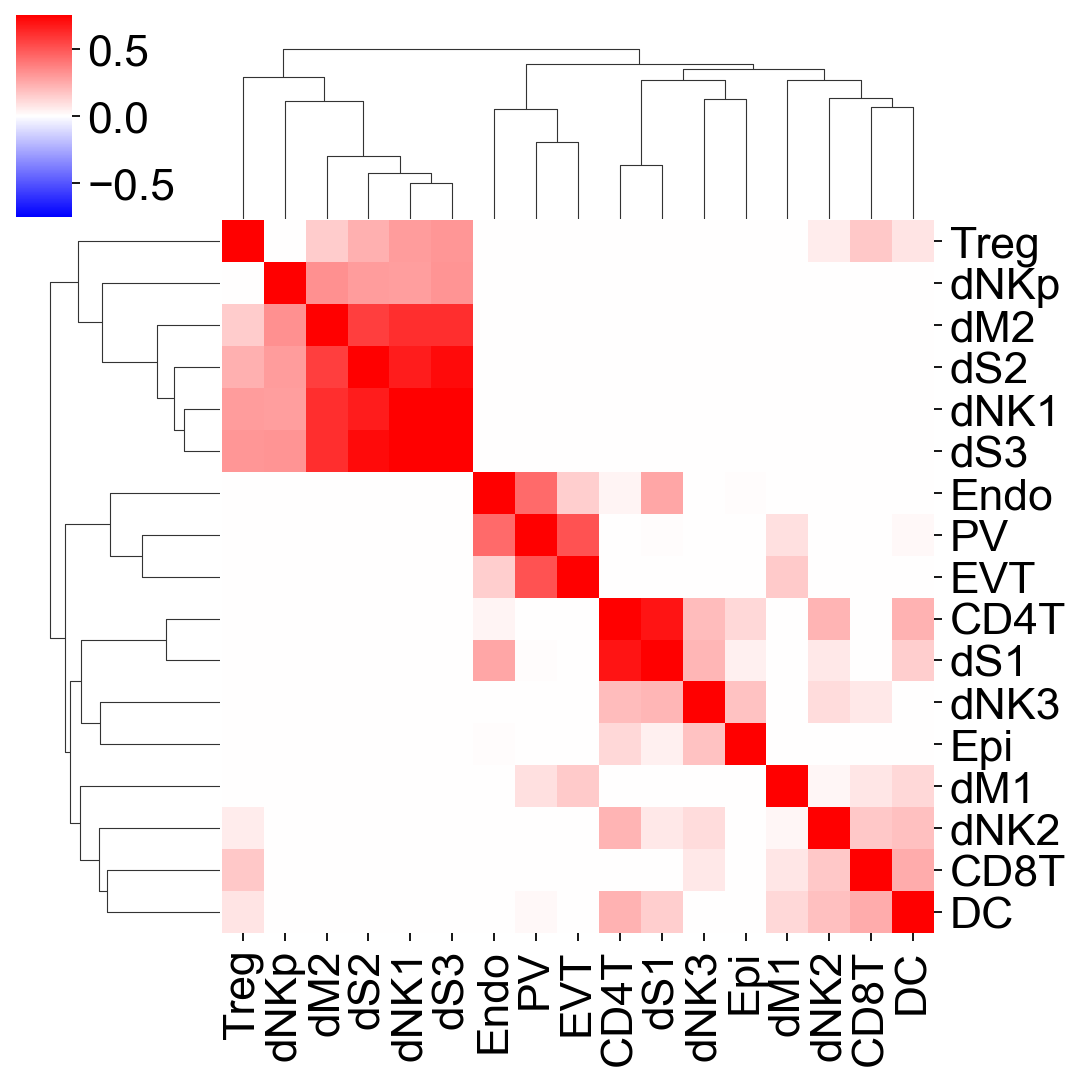

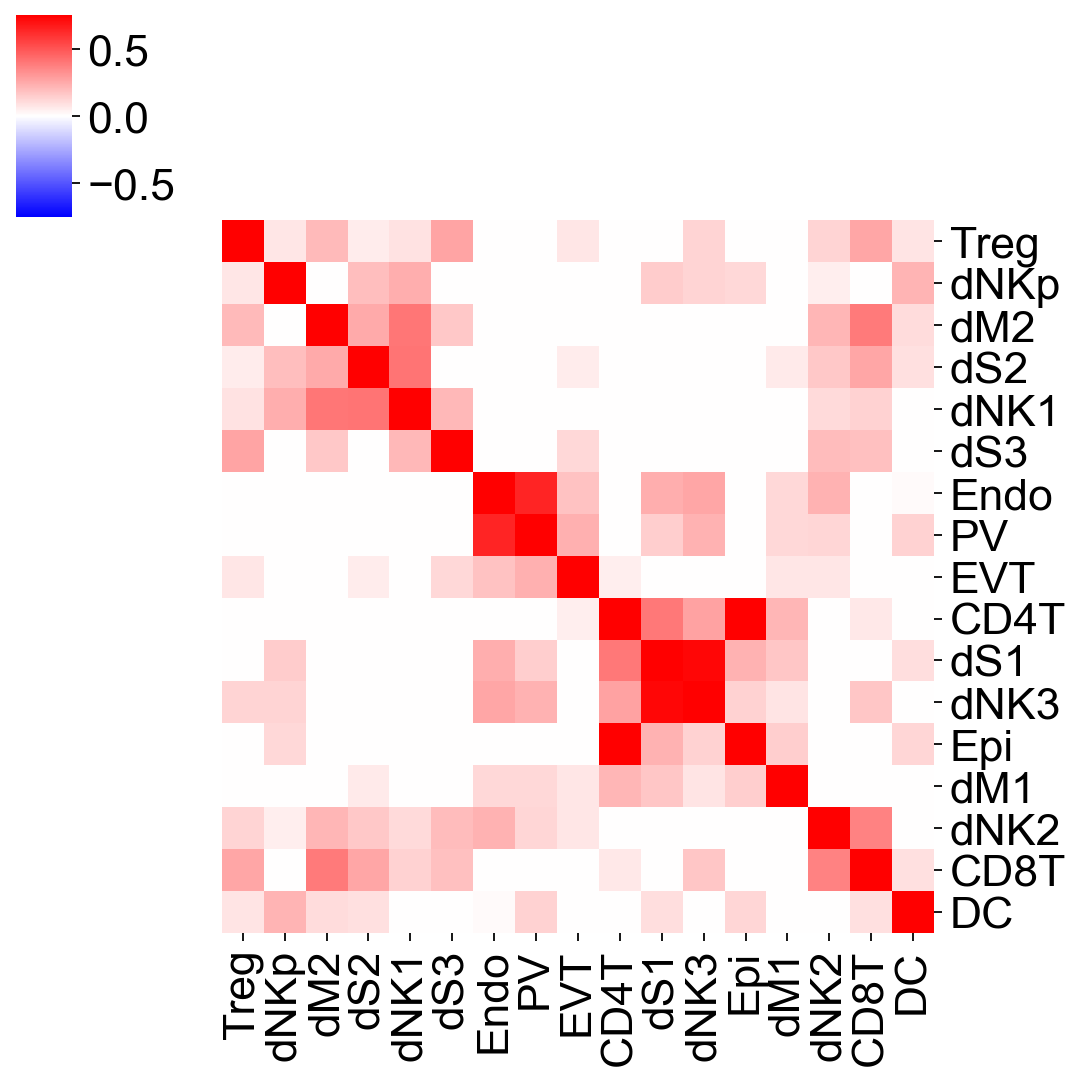

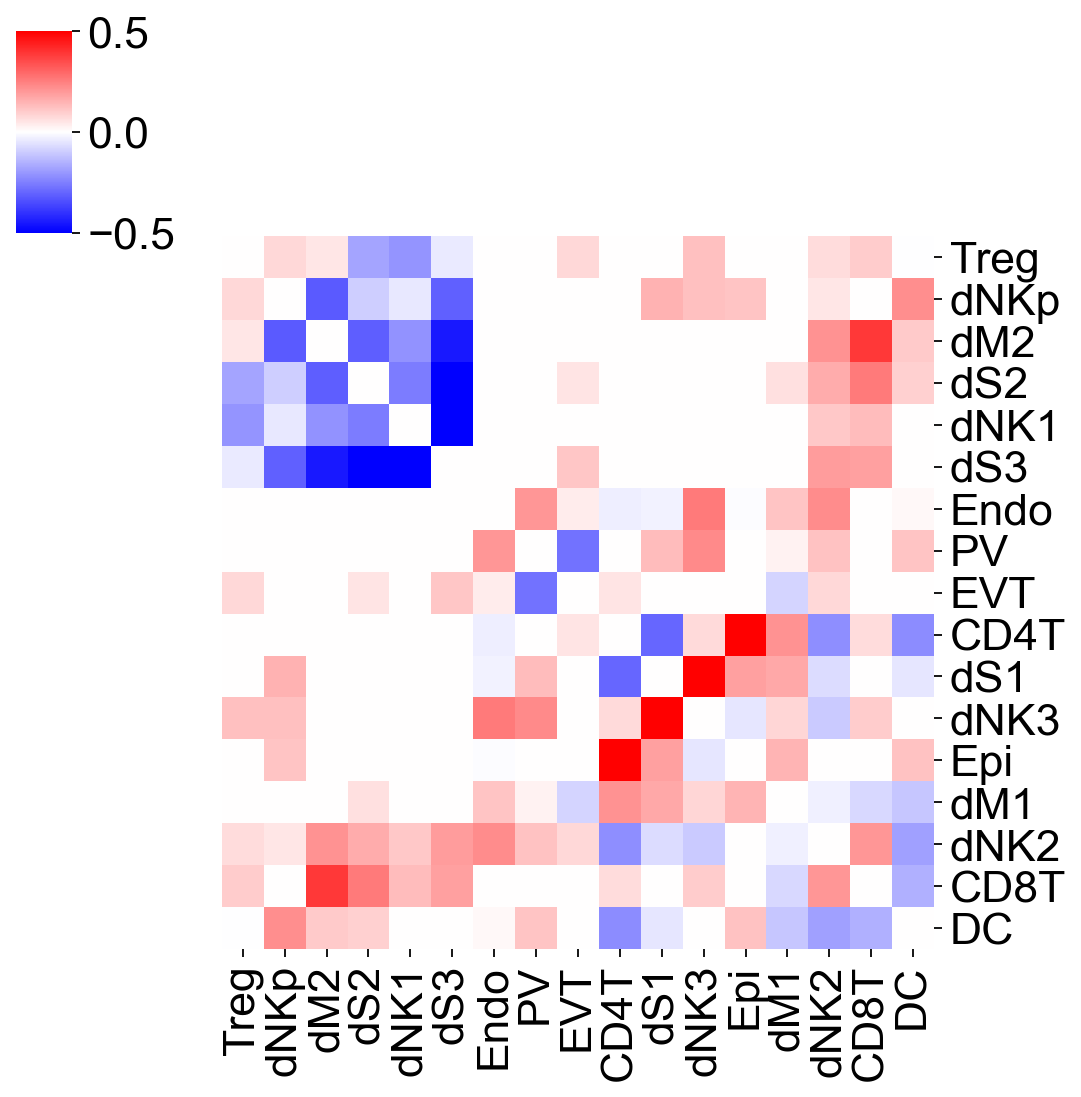

In [44]:
g = sns.clustermap(mean_norm_corr_df, method='weighted', cmap='bwr', figsize=(7,7), 
                   xticklabels=True, yticklabels=True, vmin=-.75, vmax=.75)
sns.clustermap(mean_rpl_corr_df.loc[g.data2d.index, g.data2d.index], row_cluster=False, col_cluster=False, 
               cmap='bwr', figsize=(7,7), xticklabels=True, yticklabels=True, vmin=-.75, vmax=.75)
sns.clustermap((mean_rpl_corr_df-mean_norm_corr_df).loc[g.data2d.index, g.data2d.index], 
               row_cluster=False, col_cluster=False, 
               cmap='bwr', figsize=(7,7), xticklabels=True, yticklabels=True, vmin=-.5, vmax=.5)